# LSTM-Based Next-Hour Temperature Forecasting

This notebook builds and trains a multivariate LSTM model to predict
the next-hour temperature using historical temperature, humidity, and
pressure data from NOAA (Kochi, 2020–2024).


In [1]:
!pip install tensorflow

In [2]:
import tensorflow as tf
tf.__version__

'2.20.0'

In [3]:
import pandas as pd
import numpy as np

df = pd.read_csv("../data/processed/kochi_weather_scaled.csv")
df.head()

,temperature,humidity,pressure,DATE
0,0.256410,0.875419,0.580645,2020-01-01 00:00:00
1,0.346154,0.677645,0.709677,2020-01-01 03:00:00
2,0.615385,0.407319,0.698925,2020-01-01 06:00:00
3,0.730769,0.343195,0.559140,2020-01-01 09:00:00
4,0.602564,0.443983,0.537634,2020-01-01 12:00:00


In [4]:
data = df[['temperature', 'humidity', 'pressure']].values
TIME_STEPS =24

def create_sequences(data, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps])
        y.append(data[i + time_steps])  # next hour: all 3 values
    return np.array(X), np.array(y)

X, y = create_sequences(data, TIME_STEPS)

X.shape, y.shape


((16187, 24, 3), (16187, 3))

In [5]:
# Time aware split
train_size = int(0.7 * len(X))
val_size = int(0.85 * len(X))

X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:val_size], y[train_size:val_size]
X_test, y_test = X[val_size:], y[val_size:]

In [6]:
# Building multioutput LSTM

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(TIME_STEPS, 3)),
    LSTM(32),
    Dense(3)   # temperature, humidity, pressure
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mse'
)

model.summary()


C:\Users\USER01\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 24, 64)              │          17,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 3)                   │              99 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 29,923 (116.89 KB)

 Trainable params: 29,923 (116.89 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# Training the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=32
)

Epoch 1/30
355/355 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 0.0205 - val_loss: 0.0146
Epoch 2/30
355/355 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 0.0142 - val_loss: 0.0105
Epoch 3/30
355/355 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 0.0081 - val_loss: 0.0097
Epoch 4/30
355/355 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 0.0072 - val_loss: 0.0089
Epoch 5/30
355/355 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.0066 - val_loss: 0.0075
Epoch 6/30
355/355 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - loss: 0.0064 - val_loss: 0.0082
Epoch 7/30
355/355 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 0.0063 - val_loss: 0.0080
Epoch 8/30
355/355 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.0062 - val_loss: 0.0081
Epoch 9/30
355/355 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 0.0061 - val_loss: 0.0082
Epoch 10/30
355/355 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 0.0060 - val_loss: 0.0077
Epoch 11/30
355/355 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.0060 - val_loss: 0.0076
Epoch 12/30
355/355 ━━━━━━━━━━━━━━━━━

In [8]:
# Evaluating Model
from sklearn.metrics import mean_absolute_error, mean_squared_error

y_pred = model.predict(X_test)

mae_temp = mean_absolute_error(y_test[:,0], y_pred[:,0])
mae_hum  = mean_absolute_error(y_test[:,1], y_pred[:,1])
mae_pres = mean_absolute_error(y_test[:,2], y_pred[:,2])

rmse_temp = np.sqrt(mean_squared_error(y_test[:,0], y_pred[:,0]))
rmse_hum  = np.sqrt(mean_squared_error(y_test[:,1], y_pred[:,1]))
rmse_pres = np.sqrt(mean_squared_error(y_test[:,2], y_pred[:,2]))

mae_temp, mae_hum, mae_pres, rmse_temp, rmse_hum, rmse_pres

76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


(0.08950835263358117,
 0.08842608425250428,
 0.06287871516376449,
 np.float64(0.1082893386182886),
 np.float64(0.10943472989041804),
 np.float64(0.07644708066687303))

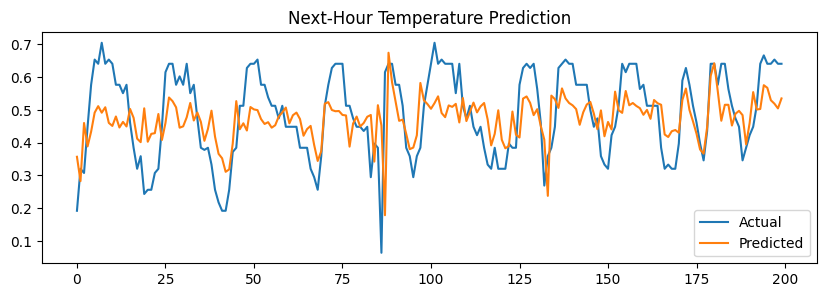

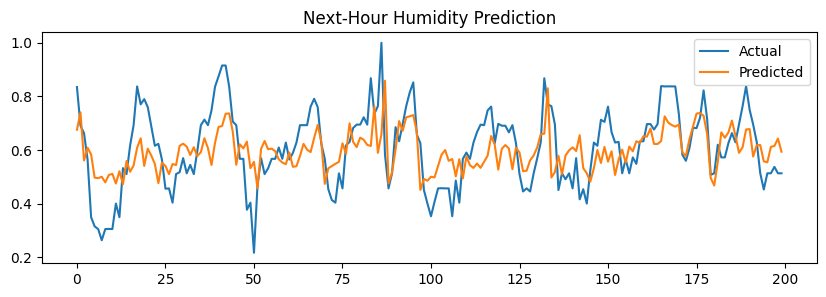

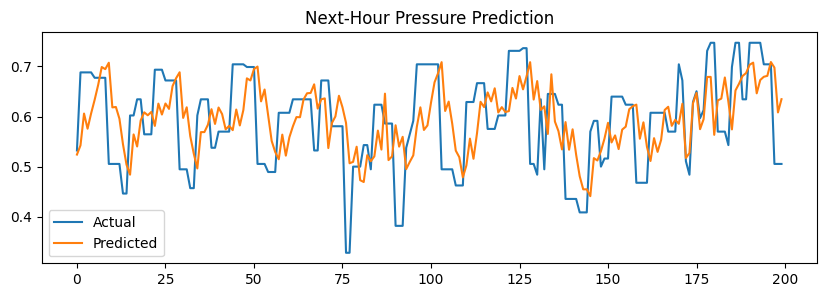

In [9]:
# Visualize Predictions
import matplotlib.pyplot as plt

labels = ['Temperature', 'Humidity', 'Pressure']

for i in range(3):
    plt.figure(figsize=(10,3))
    plt.plot(y_test[:200, i], label='Actual')
    plt.plot(y_pred[:200, i], label='Predicted')
    plt.title(f"Next-Hour {labels[i]} Prediction")
    plt.legend()
    plt.show()


In [10]:
#Saving the model
model.save("../models/kochi_lstm_next_hour_multivariate.keras")